Training the model

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
pip install pytictoc

In [ ]:
import numpy as np
import keras
import sklearn as sk
import cv2
from keras.applications.resnet import ResNet50
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, LSTM, ConvLSTM2D, Reshape, Conv2D, Dropout, BatchNormalization
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers.wrappers import TimeDistributed
import glob
import os
import tensorflow as tf
import json
from keras.models import model_from_json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load data with npy formats
X = np.load("/content/drive/My Drive/CSCE636/10_Dataset/raw_data.npy")
y = np.load("/content/drive/My Drive/CSCE636/10_Dataset/raw_label.npy")
times = np.load("/content/drive/My Drive/CSCE636/10_Dataset/times.npy")

In [ ]:
len(X)

5900

In [ ]:
#X = X/255

In [ ]:
#Generating 20 frames out of each videos
num_frames = 20
len_X = len(X)
num_videos = len_X/num_frames
#70% of data splitted for training 30% for testing
percentage = 0.7

In [ ]:
#splitting the data
X_train = X[:int(percentage*num_videos)*num_frames]
y_train = y[:int(percentage*num_videos)*num_frames]
X_test = X[int(percentage*num_videos)*num_frames:]
y_test = y[int(percentage*num_videos)*num_frames:]
times_train = times[:int(percentage*num_videos)*num_frames]
times_test = times[int(percentage*num_videos)*num_frames:]

In [ ]:
#applying transfer learnign (the first layer is removed)
ResNet = ResNet50(include_top=False)

ResNet50_Model_base = Model(inputs = ResNet.input, outputs = ResNet.get_layer("conv5_block3_add").output)

all_layers = ResNet50_Model_base.layers

for layer in ResNet50_Model_base.layers:
    layer.trainable = False #ResNets weights will not be trained

#Assuming the input frames have the Height: 224 and Width: 224 pixels
Input_to_ResNet = Input(shape=(224, 224, 3),name = 'ResNet50')

ResNet_last_layer = ResNet50_Model_base(Input_to_ResNet)

In [ ]:
#showing the last layer in ResNet
ResNet.output_names

['conv5_block3_out']

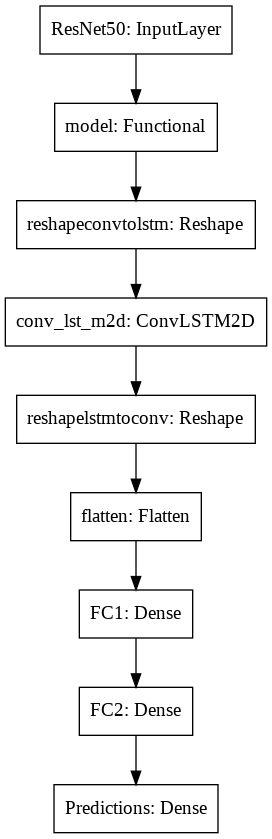

In [ ]:
x = ResNet_last_layer #Modified ResNet

#Add the fully-connected layers 
conv_to_LSTM_dims = (1,7,7,2048)
x = Reshape(target_shape=conv_to_LSTM_dims, name='reshapeconvtolstm')(x)
x = ConvLSTM2D(filters=8, kernel_size=(3, 3), input_shape=(None, 20, 7, 7, 2048), padding='same')(x)  #input_shape=(samples, time, rows, cols, channels)

LSTM_to_conv_dims = (7,7,8)
x = Reshape(target_shape=LSTM_to_conv_dims, name='reshapelstmtoconv')(x)

x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu', name='FC1')(x)
x = Dense(1024, activation='relu', name='FC2')(x)
x = Dense(1, activation='sigmoid', name='Predictions')(x) #1 for binary output
ResNet_for_TL = Model(Input_to_ResNet, x)
ResNet_for_TL.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

plot_model(ResNet_for_TL)

Epoch 1/60
58/58 [==============================] - 176s 3s/step - loss: 0.7023 - accuracy: 0.5175 - val_loss: 0.6295 - val_accuracy: 0.7083
Epoch 2/60
58/58 [==============================] - 173s 3s/step - loss: 0.6439 - accuracy: 0.6373 - val_loss: 0.5592 - val_accuracy: 0.7967
Epoch 3/60
58/58 [==============================] - 175s 3s/step - loss: 0.5763 - accuracy: 0.7488 - val_loss: 0.5038 - val_accuracy: 0.8598
Epoch 4/60
58/58 [==============================] - 174s 3s/step - loss: 0.5322 - accuracy: 0.8086 - val_loss: 0.4591 - val_accuracy: 0.8801
Epoch 5/60
58/58 [==============================] - 173s 3s/step - loss: 0.4985 - accuracy: 0.8418 - val_loss: 0.4221 - val_accuracy: 0.8813
Epoch 6/60
58/58 [==============================] - 172s 3s/step - loss: 0.4675 - accuracy: 0.8522 - val_loss: 0.3916 - val_accuracy: 0.8851
Epoch 7/60
58/58 [==============================] - 173s 3s/step - loss: 0.4456 - accuracy: 0.8480 - val_loss: 0.3656 - val_accuracy: 0.8889
Epoch 8/60
58

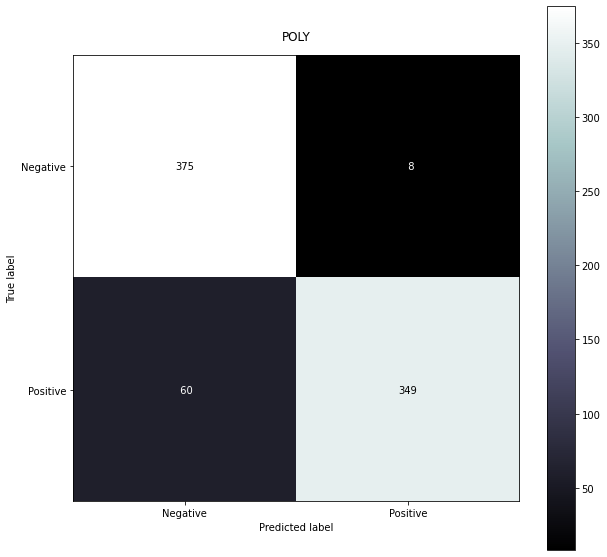

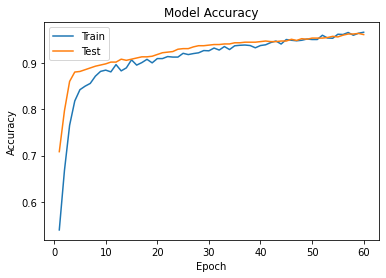

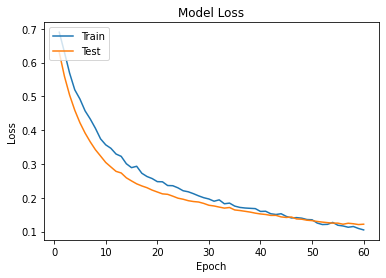

INFO:tensorflow:Assets written to: /content/drive/My Drive/CSCE636/New_Code/folderResultModel/CSCE636-Model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/CSCE636/New_Code/folderResultModel/CSCE636-Model/assets


In [ ]:
ResNet_for_TL.fit(x=X_train, y = y_train, batch_size=58, epochs=60, validation_data=(X_test, y_test))

In [ ]:
ResNet50_Model_base.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
plot_model(ResNet50_Model_base)

In [ ]:
ResNet.output_names

['conv5_block3_out']

In [ ]:
# serialize model to JSON
ResNet50_json = ResNet_for_TL.to_json()
with open("/content/drive/My Drive/CSCE636/10_Saved_Model/ResNet50.json", "w") as json_file:
    json_file.write(ResNet50_json)
# serialize weights to HDF5
ResNet_for_TL.save_weights("/content/drive/My Drive/CSCE636/10_Saved_Model/ResNet50.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:

# load json and create model
ResNet50_json_file = open('/content/drive/My Drive/CSCE636/10_Saved_Model/ResNet50.json', 'r')
loaded_model_json = ResNet50_json_file.read()
ResNet50_json_file.close()
ResNet50_loaded = model_from_json(loaded_model_json)
# load weights into new model
ResNet50_loaded.load_weights("/content/drive/My Drive/CSCE636/10_Saved_Model/ResNet50.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
u_test = ResNet50_loaded.predict((X_test))

In [ ]:
y_test[80:160]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
ResNet50_loaded.predict(X_test[90].reshape(1,224,224,3))

array([[0.05646913]], dtype=float32)

In [ ]:
json_array = np.stack((times_test, np.reshape(u_test, (-1,))), axis = 1)
json_list = np.ndarray.tolist(json_array)
json_dict = {"clap": json_list}
with open('/content/drive/My Drive/CSCE636/10_JSON/timeLabel.json', 'w') as outfile:
    json.dump(json_dict, outfile)

In [ ]:
u_test

array([[2.0864990e-14],
       [7.3458430e-08],
       [1.7466903e-10],
       ...,
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [ ]:
path_test = "/content/drive/My Drive/CSCE636/10_test/pick up things from floor.mp4"

In [ ]:
import pytictoc

time_print = pytictoc.TicToc()
time_print.tic()
print(time_print)
videos = []
labels_2d = []
num_frames = 100
frame_rate = 5
time_3d = []
time_2d = []
i=0
for path in range(2):
  
  vidcap = cv2.VideoCapture(path_test)
  fps = vidcap.get(cv2.CAP_PROP_FPS)
  success, image = vidcap.read()
  frames = []
  

  time = []
  count = 0  # control to have the same number of frames
  count_fps = 0
  while success:
    
    
    success, image = vidcap.read()
    count += 1
    if(type(image).__module__ == np.__name__):
      new_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
      
      frames.append(new_image)
      time.append(count_fps*(1/fps))
      count_fps += 1
      if count==num_frames:
        count_fps = 0
        print("Frames_", str(count),", video_", str(i), "Done, Time_Elapsed: ", str(round(time_print.tocvalue(),3)), " Seconds")
        videos.append(frames)
        time_3d.append(time)
        count = 0
        frames = []
        time = []

  if (count < num_frames):
    while (count > 0 and count <= num_frames):
      frames.append(new_image)    # if the number of frames is lower than the num_frames, repeat the last image to reach num_frames
      count +=1
      time.append(count_fps*(1/fps))
      count_fps += 1
      
    videos.append(frames)
    time_3d.append(time)
  
  i+=1
  print("Video_", str(i),"Done, Time_Elapsed: ", str(round(time_print.tocvalue(),3)), " Seconds")


videos_2d_len = len(videos)
videos_3d = np.array(videos)

labels_2d = np.zeros((len(videos_3d),num_frames))
labels_2d[0:videos_2d_len,:] = 1

time_3d = np.array(time_3d)

Frames_ 100 , video_ 0 Done, Time_Elapsed:  0.593  Seconds
Frames_ 100 , video_ 0 Done, Time_Elapsed:  0.88  Seconds
Frames_ 100 , video_ 0 Done, Time_Elapsed:  1.168  Seconds
Frames_ 100 , video_ 0 Done, Time_Elapsed:  1.457  Seconds
Frames_ 100 , video_ 0 Done, Time_Elapsed:  1.759  Seconds
Frames_ 100 , video_ 0 Done, Time_Elapsed:  2.052  Seconds
Frames_ 100 , video_ 0 Done, Time_Elapsed:  2.355  Seconds
Frames_ 100 , video_ 0 Done, Time_Elapsed:  2.65  Seconds
Frames_ 100 , video_ 0 Done, Time_Elapsed:  2.944  Seconds
Frames_ 100 , video_ 0 Done, Time_Elapsed:  3.239  Seconds
Frames_ 100 , video_ 0 Done, Time_Elapsed:  3.527  Seconds
Frames_ 100 , video_ 0 Done, Time_Elapsed:  3.821  Seconds
Frames_ 100 , video_ 0 Done, Time_Elapsed:  4.116  Seconds
Frames_ 100 , video_ 0 Done, Time_Elapsed:  4.406  Seconds
Frames_ 100 , video_ 0 Done, Time_Elapsed:  4.697  Seconds
Frames_ 100 , video_ 0 Done, Time_Elapsed:  4.987  Seconds
Frames_ 100 , video_ 0 Done, Time_Elapsed:  5.278  Seconds

In [ ]:
# ind = list(np.random.randint(0,len(videos_3d)-1,size=len(videos_3d)))
videos_3d_temp = videos_3d
videos_2d_shuffled = np.reshape(videos_3d_temp, (-1,224,224,3))
videos_2d_shuffled = videos_2d_shuffled[:len(videos_2d_shuffled):frame_rate]

time_3d_temp = time_3d
time_2d_shuffled = np.reshape(time_3d_temp, (-1,1))
time_2d_shuffled = time_2d_shuffled[:len(time_2d_shuffled):frame_rate]
time_2d_shuffled = time_2d_shuffled.T[0]

labels_2d_temp = labels_2d
labels_2d_shuffled = labels_2d_temp.flatten()
labels_2d_shuffled = labels_2d_shuffled[:len(labels_2d_shuffled):frame_rate]

In [ ]:
u_test = ResNet50_loaded.predict(videos_2d_shuffled)

In [ ]:
u_test.shape

In [ ]:
len(u_test)//frame

In [ ]:
frame

Text(0.5, 0, 'frame number')

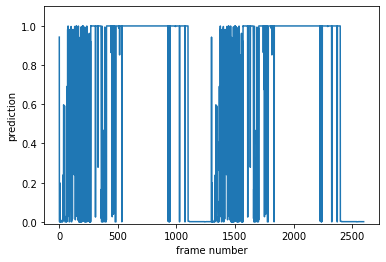

In [ ]:
plt.plot(u_test)
plt.ylim(-.01,1.1)
plt.ylabel('prediction')
plt.xlabel('frame number')

[0.99991906]
time: [28.  28.2 28.4 28.6 28.8 29.  29.2 29.4 29.6 29.8 30.  30.2 30.4 30.6
 30.8 31.  31.2 31.4 31.6 31.8]
[0.9639169]
time: [32.  32.2 32.4 32.6 32.8 33.  33.2 33.4 33.6 33.8 34.  34.2 34.4 34.6
 34.8 35.  35.2 35.4 35.6 35.8]
[0.9999865]
time: [42.  42.2 42.4 42.6 42.8 43.  43.2 43.4 43.6 43.8 44.  44.2 44.4 44.6
 44.8 45.  45.2 45.4 45.6 45.8]
[0.9920405]
time: [50.  50.2 50.4 50.6 50.8 51.  51.2 51.4 51.6 51.8 52.  52.2 52.4 52.6
 52.8 53.  53.2 53.4 53.6 53.8]
[0.9999838]
time: [54.  54.2 54.4 54.6 54.8 55.  55.2 55.4 55.6 55.8 56.  56.2 56.4 56.6
 56.8 57.  57.2 57.4 57.6 57.8]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


[0.9999798]
time: [56.  56.2 56.4 56.6 56.8 57.  57.2 57.4 57.6 57.8 58.  58.2 58.4 58.6
 58.8 59.  59.2 59.4 59.6 59.8]
[0.99999714]
time: [58.  58.2 58.4 58.6 58.8 59.  59.2 59.4 59.6 59.8 60.  60.2 60.4 60.6
 60.8 61.  61.2 61.4 61.6 61.8]
[0.99999845]
time: [60.  60.2 60.4 60.6 60.8 61.  61.2 61.4 61.6 61.8 62.  62.2 62.4 62.6
 62.8 63.  63.2 63.4 63.6 63.8]
[0.99998635]
time: [62.  62.2 62.4 62.6 62.8 63.  63.2 63.4 63.6 63.8 64.  64.2 64.4 64.6
 64.8 65.  65.2 65.4 65.6 65.8]
[0.9999984]
time: [64.  64.2 64.4 64.6 64.8 65.  65.2 65.4 65.6 65.8 66.  66.2 66.4 66.6
 66.8 67.  67.2 67.4 67.6 67.8]
[1.]
time: [66.  66.2 66.4 66.6 66.8 67.  67.2 67.4 67.6 67.8 68.  68.2 68.4 68.6
 68.8 69.  69.2 69.4 69.6 69.8]
[0.9999984]
time: [68.  68.2 68.4 68.6 68.8 69.  69.2 69.4 69.6 69.8 70.  70.2 70.4 70.6
 70.8 71.  71.2 71.4 71.6 71.8]
[0.9999998]
time: [70.  70.2 70.4 70.6 70.8 71.  71.2 71.4 71.6 71.8 72.  72.2 72.4 72.6
 72.8 73.  73.2 73.4 73.6 73.8]
[1.]
time: [72.  72.2 72.4 72.6 72.8

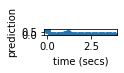

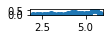

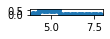

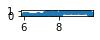

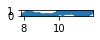

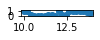

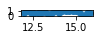

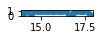

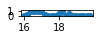

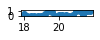

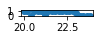

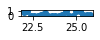

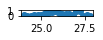

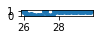

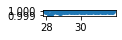

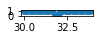

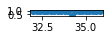

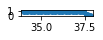

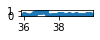

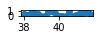

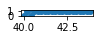

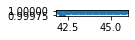

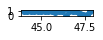

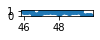

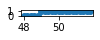

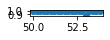

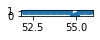

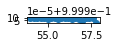

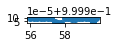

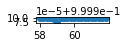

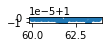

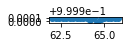

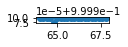

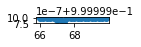

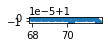

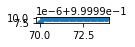

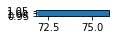

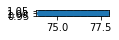

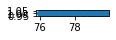

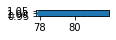

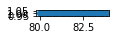

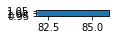

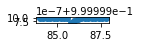

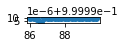

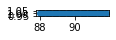

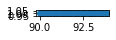

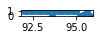

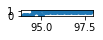

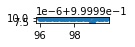

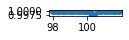

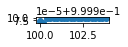

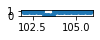

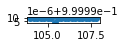

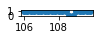

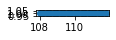

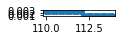

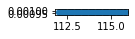

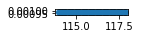

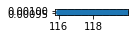

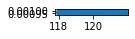

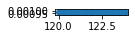

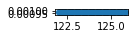

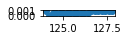

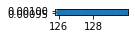

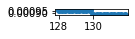

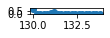

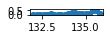

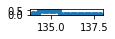

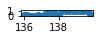

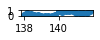

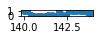

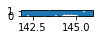

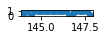

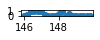

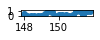

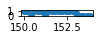

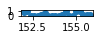

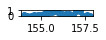

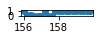

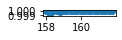

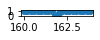

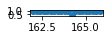

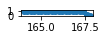

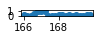

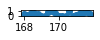

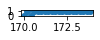

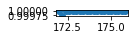

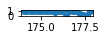

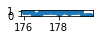

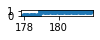

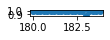

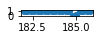

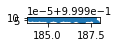

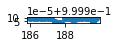

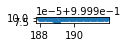

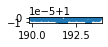

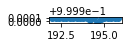

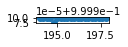

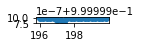

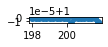

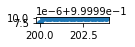

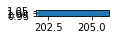

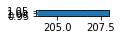

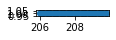

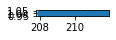

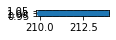

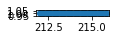

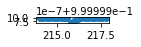

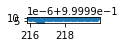

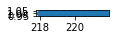

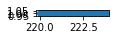

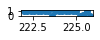

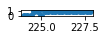

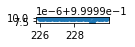

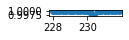

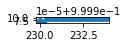

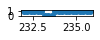

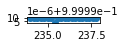

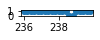

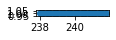

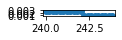

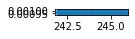

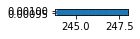

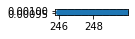

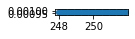

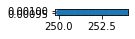

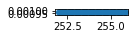

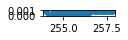

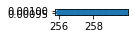

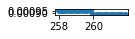

In [ ]:
clip_length = int(num_frames/frame_rate)
num_vid_parts = int((len(u_test)/clip_length))
        
num_col = 4
num_row = math.ceil(num_vid_parts/num_col)

conf=[]
sec_per_batch = 2
for i in np.arange(int((len(u_test)/clip_length))):
    
    plt.figure()
    time = time_2d_shuffled[i*clip_length: (i+1)*clip_length] + i*sec_per_batch
    plt.subplot(num_row, num_col, i+1)
    conf=u_test[i*clip_length: (i+1)*clip_length]
    ave_conf=sum(conf)/len(conf)
    if ave_conf > 0.95:
      print(ave_conf)
      print('time:',time)
    plt.scatter(x = time, y = u_test[i*clip_length: (i+1)*clip_length])
    
    if i == 0:
        plt.xlabel("time (secs)")
        plt.ylabel("prediction")
plt.show()  
# print(conf.shape)
# for i in range(len(conf))
#   print(sum(conf[i][0])/len(conf[i]))

In [ ]:
# frame = num_frames/frame_rate
# xxx = np.arange(0, 19, 1/frame)
# plt.plot(xxx, u_test)
plt.plot(u_test)
plt.ylim(-.01,1.1)
plt.ylabel('prediction')
plt.xlabel('frame number')

Finding youtube videos

In [ ]:

#Search for Youtube videos
!pip install pytube
!pip install youtubesearchpython
# from youtubesearchpython import VideosSearch
!pip install youtube_searchimport os
# from youtube_search import YoutubeSearch
from pytube import YouTube
!pip install youtube-search-python
from youtubesearchpython import VideosSearch
!pip install youtube_dl
from __future__ import unicode_literals
import youtube_dl


In [ ]:
import pytube  
from pytube import YouTube  
import urllib.request
import requests
# yt = YouTube("https://www.youtube.com/watch?v=n06H7OcPd-g")
# yt = yt.get('mp4', '720p')
# yt.download('/path/to/download/directory')
searchIDs=['pick up something','lift something floor','messy room','house cleaning']
# os.chdir("/content/drive/My Drive/CSCE636/3_test_Youtube")
downVid=[]
for searchID in searchIDs:
    vidSearch = VideosSearch(searchID, limit=5)
    print(searchID)
    for i in range(0, 5):
      id=vidSearch.result()['result'][i]['id']
      url='https://www.youtube.com/watch?v='+id
      print('https://www.youtube.com/watch?v='+id)
      youtube = pytube.YouTube(url)  
      video = youtube.streams.first()  
      video.download('/content/drive/My Drive/CSCE636/10_test')   
    # with open("/content/gdrive/My Drive/CSCE636/3_test_Youtube", "wb") as file: 
    #   for block in r.iter_content(chunk_size = 1024):
    #       if block: 
    #           file.write(block) 

In [ ]:
def json(dest):

    jsonData=[]
    jsonContent=[]
    for idx,element in enumerate(testVideos):
        if testPrediction[idx]>=modelThreshold:
            jsonData.append([element[0],element[2]+1,element[2]+3,testPrediction[idx]])
    print(len(jsonData))
    for element in jsonData:
        jsonContent.append({"videoId":element[0],
                            "type":"segment",
                            "startTime":element[1],
                            "endTime":element[2],
                            "observer":"CSCE636-Spring2021-baharealik-v10",
                            "isHuman":False,
                            "observation":{"label":"Pick up something from floor",
                                           "labelConfidence":str(element[3])}})
    jsonAdd=os.path.join(dest,'Submission10.json')
    with open(jsonAdd, 'w') as outfile:
        json.dump(jsonContent, outfile)

json(modelresult)

In [ ]:
import json
with open('Submission10_jsonContent.txt', 'w') as outfile:
    json.dump(submission_jsonContent, outfile)

In [ ]:
??random